In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
import Dataset

In [41]:
topdir = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/"
datasets = ["cosmics-endofrun/", "ds01/","ds02/","ds03/", "ds04/","ds05/","ds06/","ds07/",\
        "ds08/","ds09/","ds10/","ds11/","filling/", "room-temp-dark-noise/"]

ds_single = "ds04/"
config = "../configs/run7_config.yaml"

In [42]:
#load the dataset object for the single file selected
ds = Dataset.Dataset(topdir+ds_single, config)

In [4]:
#look at struck files and count the number of events in each. 
#each struck file has possibly a variable number of events, 
#and they are ordered chronologically in time based on when
#the events arrived. 
for f in ds.struck_files:
    df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
    nevts = len(df.index)
    t_i = df["Seconds"].iloc[0] #timestamp of first event in 0th channel in seconds since start of day
    t_f = df["Seconds"].iloc[1]
    #add that seconds value to the date of the dataset, in a python datetime format
    t_i = date + timedelta(seconds=t_i)
    t_f = date + timedelta(seconds=t_f)
    
    print("In file {} there are {:d} events and times ranging from {} to {}".format(f.split('/')[-1], nevts, t_i, t_f))

In file prereduced_0.p there are 75 events and times ranging from 2077-02-19 11:45:44 to 2077-02-19 11:45:44
In file prereduced_1.p there are 78 events and times ranging from 2077-02-19 11:49:07 to 2077-02-19 11:49:08
In file prereduced_10.p there are 77 events and times ranging from 2077-02-19 12:19:25 to 2077-02-19 12:19:25
In file prereduced_11.p there are 64 events and times ranging from 2077-02-19 12:22:46 to 2077-02-19 12:22:47
In file prereduced_12.p there are 61 events and times ranging from 2077-02-19 12:26:08 to 2077-02-19 12:26:08
In file prereduced_13.p there are 83 events and times ranging from 2077-02-19 12:29:32 to 2077-02-19 12:29:34
In file prereduced_14.p there are 69 events and times ranging from 2077-02-19 12:32:53 to 2077-02-19 12:32:53
In file prereduced_15.p there are 61 events and times ranging from 2077-02-19 12:36:15 to 2077-02-19 12:36:19
In file prereduced_16.p there are 72 events and times ranging from 2077-02-19 12:39:37 to 2077-02-19 12:39:37
In file prer

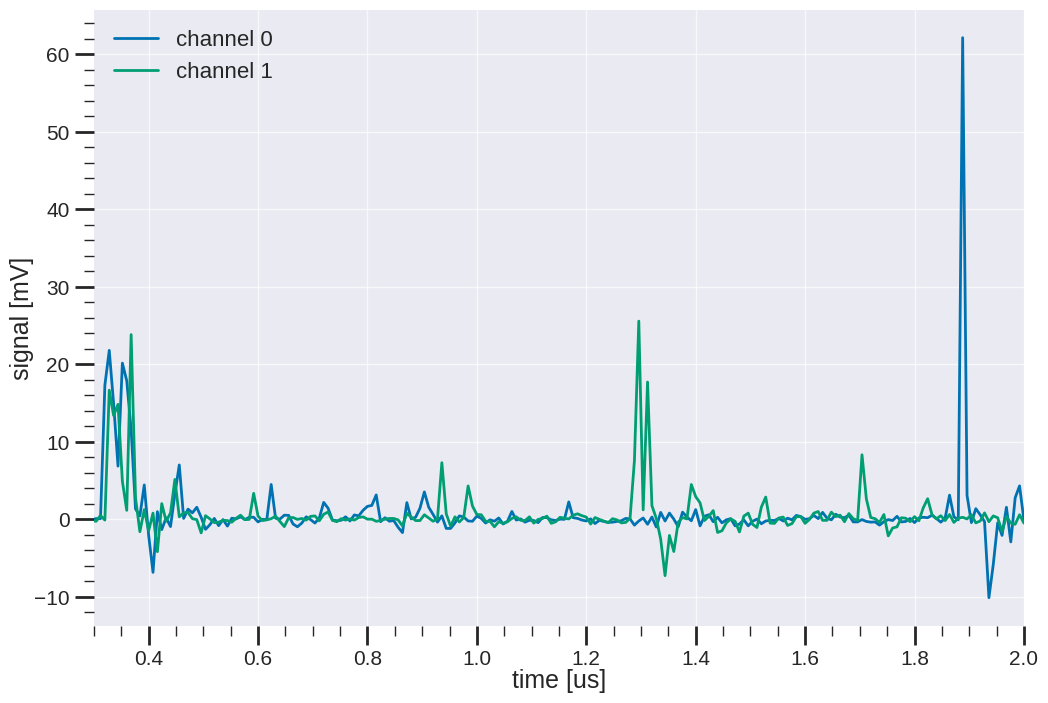

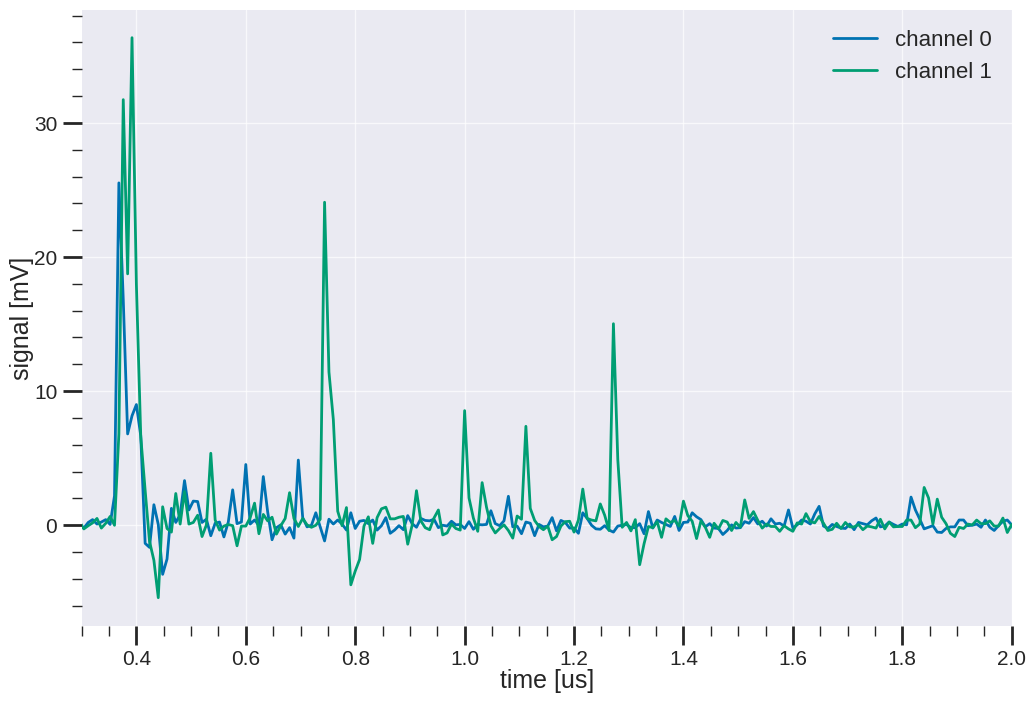

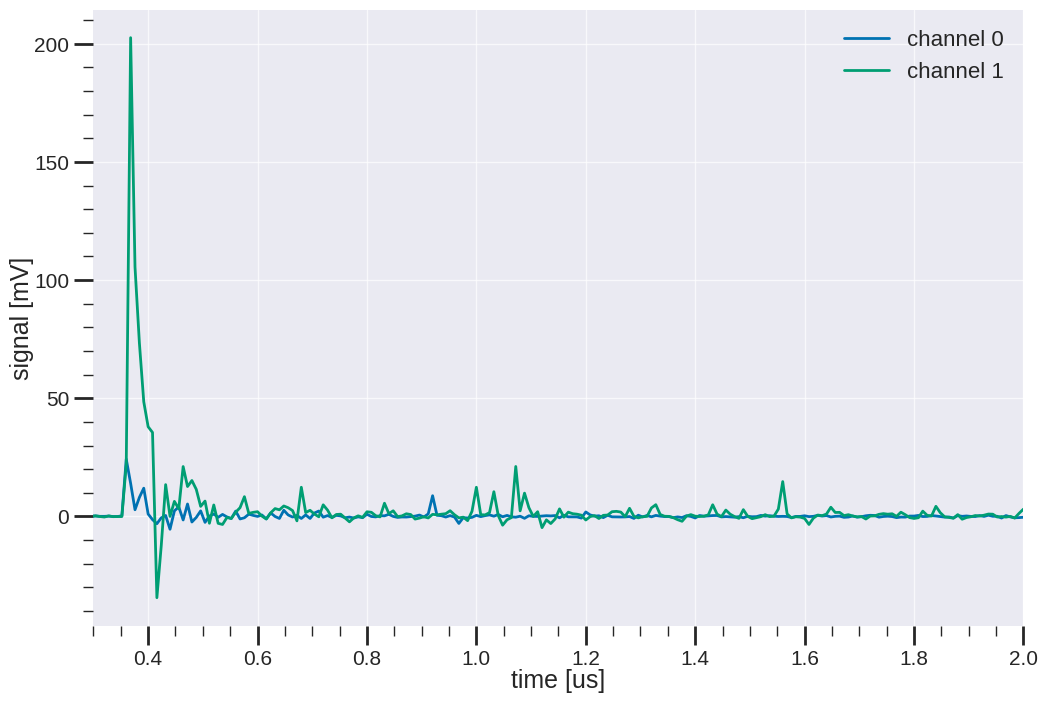

In [6]:
file_of_interest = "prereduced_6.p"

#number of plots desired
nplots = 3

#in the config file, which is loaded by the dataset object, 
#there is a parameter for sampling rate. Grab that (the dataset object has parsed the config file)
dsconf = ds.config
sampling_rate = float(dsconf["struck_reduction"]["clock"]) #Hz 
dT = 1.0/sampling_rate #seconds
dT = dT*1e6 #microseconds

for f in ds.struck_files:
    if(file_of_interest in f):
        df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
        nevts = len(df.index)
        #get random, non-repeating event numbers within the bounds of this dataframe
        rand_idx = np.random.choice(range(nevts), nplots, replace=False)
        for idx in rand_idx:
            fig, ax = plt.subplots(figsize=(12, 8))
            evt = df.iloc[idx]
            times = np.arange(0, len(evt["Data"][0])*dT, dT) #times in microseconds
            ax.plot(times, evt["Data"][0], label="channel 0")
            ax.plot(times, evt["Data"][1], label="channel 1")
            ax.set_xlabel("time [us]")
            ax.set_ylabel("signal [mV]")
            ax.set_xlim([0.3, 2])
            ax.legend()
            plt.show()

        

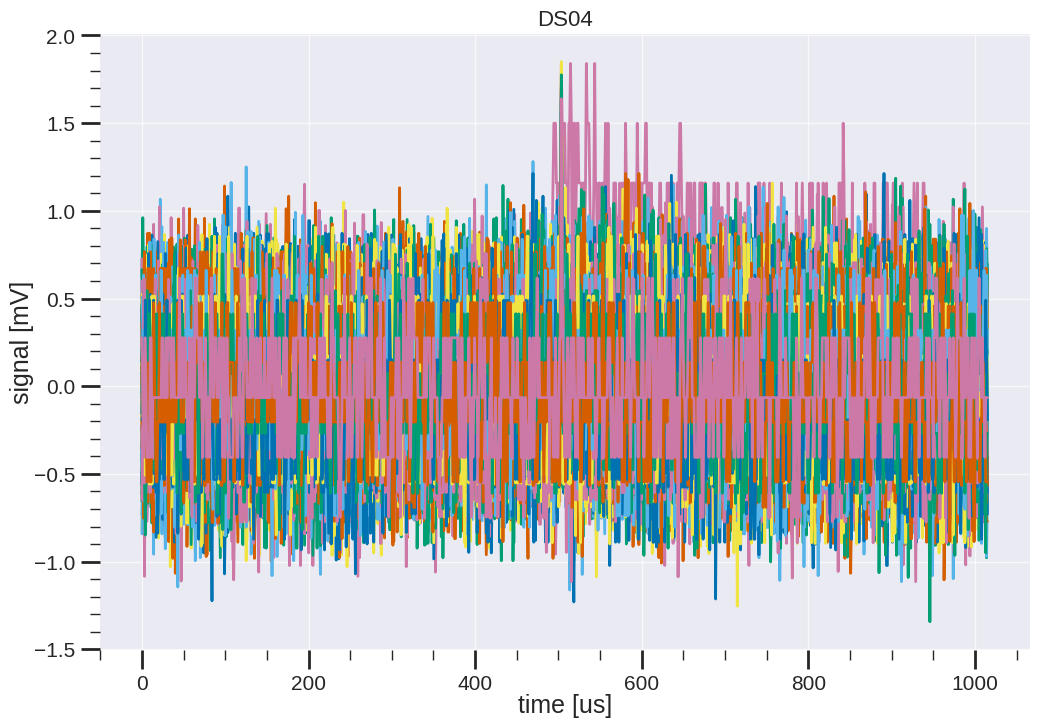

In [44]:
#plotting charge


#in the config file, which is loaded by the dataset object, 
#there is a parameter for sampling rate. Grab that (the dataset object has parsed the config file)
dsconf = ds.config
amp_th = 2

plot_trip = False
trip = [2, 15]
condition = "trip with x10 events, or x1 above range"
fig, ax = plt.subplots(figsize=(12, 8))
for f in ds.ad2_files:
    df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
    nevts = len(df.index)
    for evidx, row in df.iterrows():
        ch1 = row["Data"][0]
        dT = row["dT"]
        if(np.max(ch1) < amp_th):
            
            times = np.linspace(0, len(ch1)*dT*1e6, len(ch1)) #times in microseconds
            ax.plot(times, ch1, label="anode")
            ax.set_xlabel("time [us]")
            ax.set_ylabel("signal [mV]")
            #ax.set_title("Event number: {:d}".format(evidx))
            ax.set_title("DS04")
            #ax.legend()
            
    if(plot_trip):
        ax.fill_between(times, y1=trip[0], y2=trip[1], alpha=0.2, color='r')
        ax.annotate(condition, xy=(0, np.mean(trip)), fontsize=15)
            
plt.show()
            
            



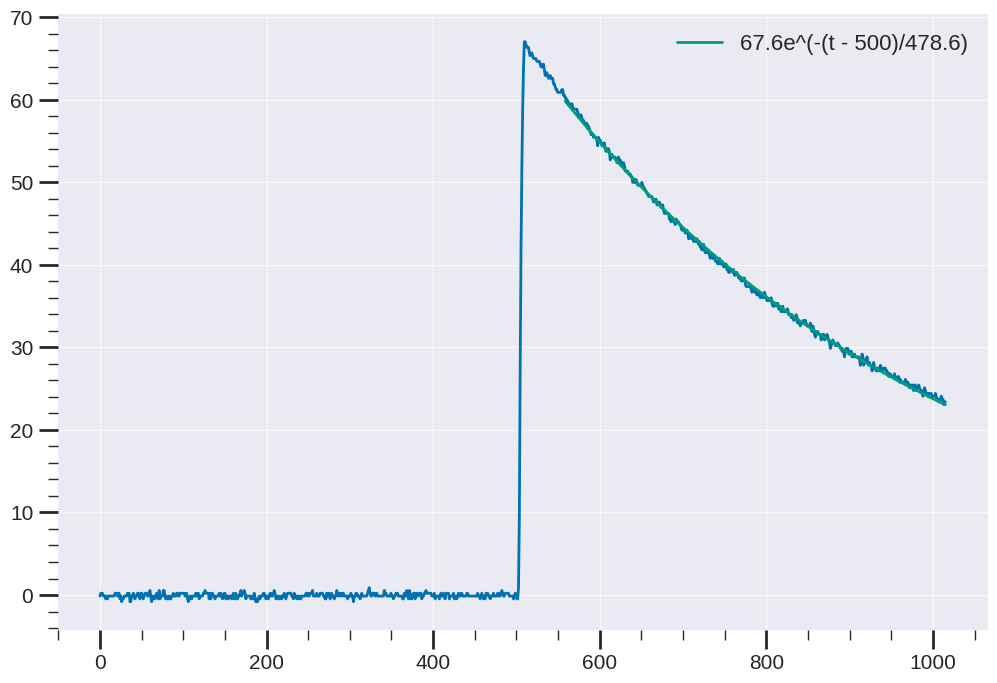

In [11]:
from scipy.optimize import curve_fit

def fitfunc(x, A, tau):
    return A*np.exp(-(x - 500)/tau)

f = ds.ad2_files[0]
df, date = pickle.load(open(f, "rb"))
evidx = 136
ev = df.iloc[evidx]
v = np.array(ev["Data"][0])
dT = ev["dT"]
ts = np.array(np.linspace(0, len(v)*dT*1e6, len(v))) #times in microseconds

b = int(len(v)*.55) #time bounding the fit
popt, pcov = curve_fit(fitfunc, ts[b:], v[b:], p0=[80, 440])

fig, ax = plt.subplots()
ax.plot(ts, v)
ax.plot(ts[b:], fitfunc(ts[b:], *popt), label="{:.1f}e^(-(t - 500)/{:.1f})".format(popt[0], popt[1]))
ax.legend()
plt.show()


['/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/ds04/prereduced_ad2.p']
